## Task 4.  Algorithms of unconditional nonlinear optimization. Stochastic and metaheuristic algorithms

### 4.1 Generate noisy data {$x_k, y_k$}, where $k = 0, 1, .. 10^{3}$, according to the rule: 

\begin{equation*}
    \\
    x_k = \frac{3k}{10^{3}},
    \; \; \;
    y_k =
    \begin{cases}
        \: -10^{2} + \delta_{k}, \; f(x_{k}) < -10^{2}
        \\
        \\
        \: f(x_{k}) + \delta_{k}, \; |f(x_{k})| \leq 10^{2},
        \\
        \\
        \: 10^{2} + \delta_{k}, \; f(x_{k}) > 10^{2}
    \end{cases}
    \; \;
    f(x) = \frac{1}{x^{2} - 3x + 2}
\end{equation*}

### where $\delta_k \sim N(0, 1)$ are values of a random variable with standard normal distribution. Approximate the data by the following rational function:

\begin{equation*}
    F(x, a, b, c, d) = \frac{ax + b}{x^{2} + cx + d}
\end{equation*}

### by means of least squares through the numerical minimization of the following function:

\begin{equation*}
    D(a, b, c, d) = \sum_{k = 0}^{1000}{(F(x_k, a, b, c, d) - y_k)^2}
\end{equation*}

### To solve the minimization problem, use Nelder-Mead algorithm, Levenberg-Marquardt algorithm and at least two of the methods among Simulated Annealing, Differential Evolution and Particle Swarm Optimization. If necessary, set the initial approximations and other parameters of the methods. Use $ \varepsilon = 0.001$ as the precision; at most 1000 iterations are allowed. 

### Visualize the data and theapproximants obtained in a single plot. Analyze and compare the results obtained (in terms of number of iterations, precision, number of function evaluations, etc.).


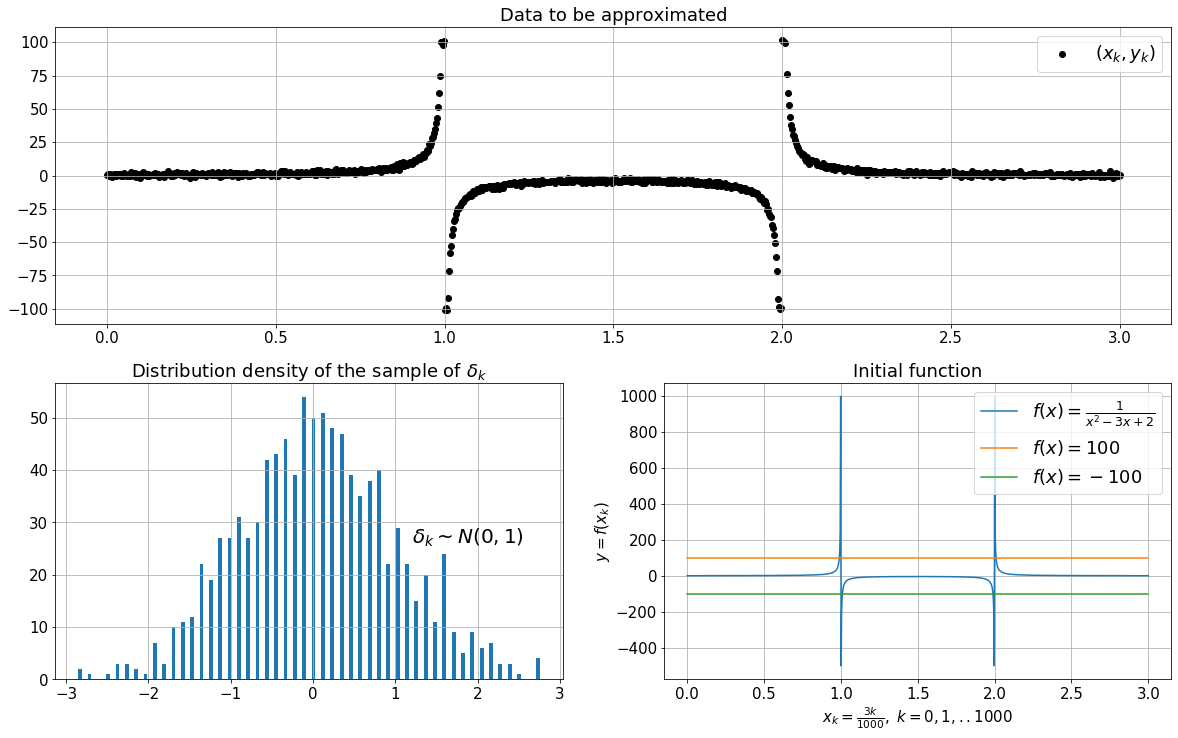

In [250]:
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.optimize import minimize, least_squares

global x_arr
global y_arr

# Data generation part:

def initial_func(x):
    return 1 / (x ** 2 - 3 * x + 2)

np.random.seed(4)
el_num = 1001
mu, sigma = 0, 1
delta_arr = np.random.normal(mu, sigma, el_num)

x_arr = np.linspace(0, 3, el_num)
y_arr = np.array([(lambda y: - 100 if (y < -100) else (100 if (y > 100) else y))(initial_func(x_arr[k])) \
                  +  delta_arr[k] for k in range(el_num)])

mpl.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize = (20, 12))
plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

plt.subplot(2, 2, 3)
plt.hist(delta_arr, bins = 50, rwidth = 0.4)
plt.text(x = 1.2, y = 26, s = r'$\delta_k \sim N(0, 1)$', fontsize = 20)
plt.title('Distribution density of the sample of $\delta_k$')
plt.grid()

plt.subplot(2, 2, 4)
x_arr = np.linspace(0, 3, el_num)
plt.plot(x_arr, initial_func(x_arr), x_arr, [100] * el_num, x_arr, [-100] * el_num)
plt.title('Initial function')
plt.legend([r'$f(x) = \frac{1}{x^2 - 3x + 2}$', r'$f(x) = 100$', r'$f(x) = -100$'], loc = 'best', fontsize = 18)
plt.xlabel(r'$x_k = \frac{3k}{1000}, \; k = 0, 1, .. 1000$')
plt.ylabel(r'$y = f(x_k)$')
plt.grid()

plt.subplot(2, 1, 1)
plt.scatter(x_arr, y_arr, c = 'k')
plt.title('Data to be approximated')
plt.legend([r'$(x_k, y_k)$'], loc = 'best', fontsize = 18)
plt.grid()
plt.show()

#fig.savefig('initial_distribution.png')

In [261]:
# Working part:

def approx_func(x, args):
    return (args[0] * x + args[1]) / (x ** 2 + args[2] * x + args[3])


def least_squares_func(args):
    return np.sum(np.square((args[0] * x_arr + args[1]) / (x_arr ** 2 + args[2] * x_arr + args[3]) - y_arr))


def gradient_num(func, args, eps = 1e-3):
    
    '''each time the gradient is calculated, the function is evaluated for 8 times'''
    
    a, b, c, d = args[:]
    
    part_deriv_a = (func([a + eps, b, c, d]) - func([a - eps, b, c, d])) / (2 * eps)
    part_deriv_b = (func([a, b + eps, c, d]) - func([a, b - eps, c, d])) / (2 * eps)
    part_deriv_c = (func([a, b, c + eps, d]) - func([a, b, c - eps, d])) / (2 * eps)
    part_deriv_d = (func([a, b, c, d + eps]) - func([a, b, c, d - eps])) / (2 * eps)
    
    return np.array([part_deriv_a,  part_deriv_b, part_deriv_c, part_deriv_d])


def Nelder_Mead(eps = 1e-3):
    
    res = minimize(least_squares_func, np.ones(4), method = 'nelder-mead', options = {'xatol': eps, 'maxiter' : 1000})
    
    return np.array([res.x[0], res.x[1], res.x[2], res.x[3], res.nit, res.nfev, least_squares_func(res.x)])


def Levenberg_Marquardt(eps = 1e-3):
        
    reg_param = 0.1
    func_eval_num, iter_num = 0, 0
    args_prev = np.array(np.ones(4))
        
    jac = np.array([gradient_num(lambda args: approx_func(x_i, args), args_prev, eps = eps / 10) for x_i in x_arr])
    inv_cond = np.linalg.inv(np.dot(jac.T, jac) + reg_param * np.diag(np.dot(jac.T, jac)) * np.eye(4))
        
    delta_arg = np.dot(inv_cond, np.dot(jac.T, y_arr - np.array([approx_func(x_i, args_prev) for x_i in x_arr])))
    args_curr = args_prev + delta_arg
    
    func_eval_num += 8
    iter_num += 1
    
    while (np.linalg.norm(args_curr - args_prev, np.inf) >= eps) and (iter_num < 1000):
        
        args_prev = args_curr[:]
        
        jac = np.array([gradient_num(lambda args: approx_func(x_i, args), args_prev, eps = eps / 10) for x_i in x_arr])
        inv_cond = np.linalg.inv(np.dot(jac.T, jac) + reg_param * np.diag(np.dot(jac.T, jac)) * np.eye(4))
        delta_arg = np.dot(inv_cond, np.dot(jac.T, y_arr - np.array([approx_func(x_i, args_prev) for x_i in x_arr])))
        
        args_curr = args_prev + delta_arg
        
        func_eval_num += 8
        iter_num += 1
    
    n_digits = abs(int(round(np.log10(eps))))
    params = [round(args_curr[i], n_digits) for i in range(4)]
    
    return np.array(params[:] + [iter_num, func_eval_num, least_squares_func(params)])


def Levenberg_Marquardt_scipy(eps = 1e-3):
    
    """
    
    ValueError: Method 'lm' doesn't work when the number of residuals is less than the number of variable
    
    What the heck does that suppose to mean?
    
    """
    
    res = least_squares(least_squares_func, np.ones(4), method = 'lm', xtol = eps)
    
    return np.array([res.x[0], res.x[1], res.x[2], res.x[3], res.njev, res.nfev, least_squares_func(res.x)])


def rand_neighbour(args, eps = 1e-2):
    
    ans = args[:]
    for i in range(len(ans)):
        ans[i] += eps * random.choices([1, -1], weights = [0.5, 0.5])[0]
    
    return ans


def simulated_annealing(max_iter = 1000):
    
    """ temperature will decrease by the law: temp[i + 1] = temp[i] - gamma,
    where gamma value depends on the maximum of iterations available, and temp[0] = 1"""
    
    func_eval_num, iter_num = 0, 0
    temp_i, gamma = 1, max_iter ** (-1)
    
    args_prev = np.array(np.ones(4))
    func_prev = least_squares_func(args_prev)
        
    args_i = rand_neighbour(args_prev)
    func_i = least_squares_func(args_i)
        
    if func_i <= func_prev:
        args_curr = args_i
    else:
        p = np.exp((func_prev - func_i) / temp_i)
        args_curr = random.choices([args_i, args_prev], weights = [p, 1 - p])[0]
    
    temp_i -= gamma
    func_eval_num += 2
    iter_num += 1

    while (temp_i > 0) and (iter_num < max_iter):
        
        args_prev = args_curr
        func_prev = least_squares_func(args_prev)
        
        args_i = rand_neighbour(args_prev)
        func_i = least_squares_func(args_i)
        
        if func_i <= func_prev:
            args_curr = args_i
        else:
            p = np.exp((func_prev - func_i) / temp_i)
            args_curr = random.choices([args_i, args_prev], weights = [p, 1 - p])[0]
        
        temp_i -= gamma
        func_eval_num += 2
        iter_num += 1
        
    return np.array([args_curr[0], args_curr[1], args_curr[2], args_curr[3], iter_num, \
                     func_eval_num, least_squares_func(args_curr)])


def differential_evolution(cross_prob = 0.5, diff_weight = 1, pop_size = 15, max_iter = 1000):
    
    func_eval_num, iter_num = 0, 0
    agent_dim = 4
    
    population = np.array([np.random.uniform(-4, 4, agent_dim) for i in range(pop_size)])     
    
    while iter_num < max_iter:
        
        for j in range(pop_size):
        
            x_agent, y_agent = population[j], []

            ind_list = [i for i in range(pop_size)]
            ind_list.remove(j)

            a_agent, b_agent, c_agent = population[random.sample(ind_list, 3)]

            for i in range(agent_dim):
                
                """ didn't understand, should we use normal or uniform distribution here """

                rule_prob = np.random.normal(0, 1, 1)[0]
                #rule_prob = uniform.rvs(size = 1)[0]
                
                if rule_prob < cross_prob:
                    y_agent.append(a_agent[i] + diff_weight * (b_agent[i] - c_agent[i]))
                else:
                    y_agent.append(x_agent[i])

            if least_squares_func(y_agent) <= least_squares_func(x_agent):
                population[j] = y_agent

            func_eval_num += 2

        iter_num += 1
    
    
    res = population[0]
    func_res = least_squares_func(res)
    func_eval_num += 1
    
    for i in range(1, pop_size):
        
        func_i = least_squares_func(population[i])
        func_eval_num += 1
        
        if func_i < func_res:
            res = population[i]
            func_res = func_i
        
    return np.array([res[0], res[1], res[2], res[3], iter_num, func_eval_num, func_res])



# Testing:--------------------------------------------------------------------------------------------------

algos_dict = {'Nelder-Mead algorithm': Nelder_Mead, \
              'Levenberg-Marquardt algorithm': Levenberg_Marquardt, \
              'Simulated annealing algorithm': simulated_annealing, \
              'Differential evolution': differential_evolution}

df = pd.DataFrame(columns = list(algos_dict.keys()), index = list('abcd')[:] + \
                  ['number of iterations', 'number of function evaluations', 'sum of squared deviations'])


for alg_name in list(algos_dict.keys()):
    
    df[alg_name] = algos_dict[alg_name]()

df

,Nelder-Mead algorithm,Levenberg-Marquardt algorithm,Simulated annealing algorithm,Differential evolution
a,-1.005526,-2.413000,1.340000,-1.007939
b,1.006017,0.333000,0.980000,1.008432
c,-2.000945,6.490000,1.100000,-2.000942
d,1.000961,-0.890000,0.540000,1.000958
number of iterations,443.000000,1000.000000,1000.000000,1000.000000
number of function evaluations,738.000000,8000.000000,2000.000000,30015.000000
sum of squared deviations,136737.531823,268712.177408,269705.188239,136738.018283


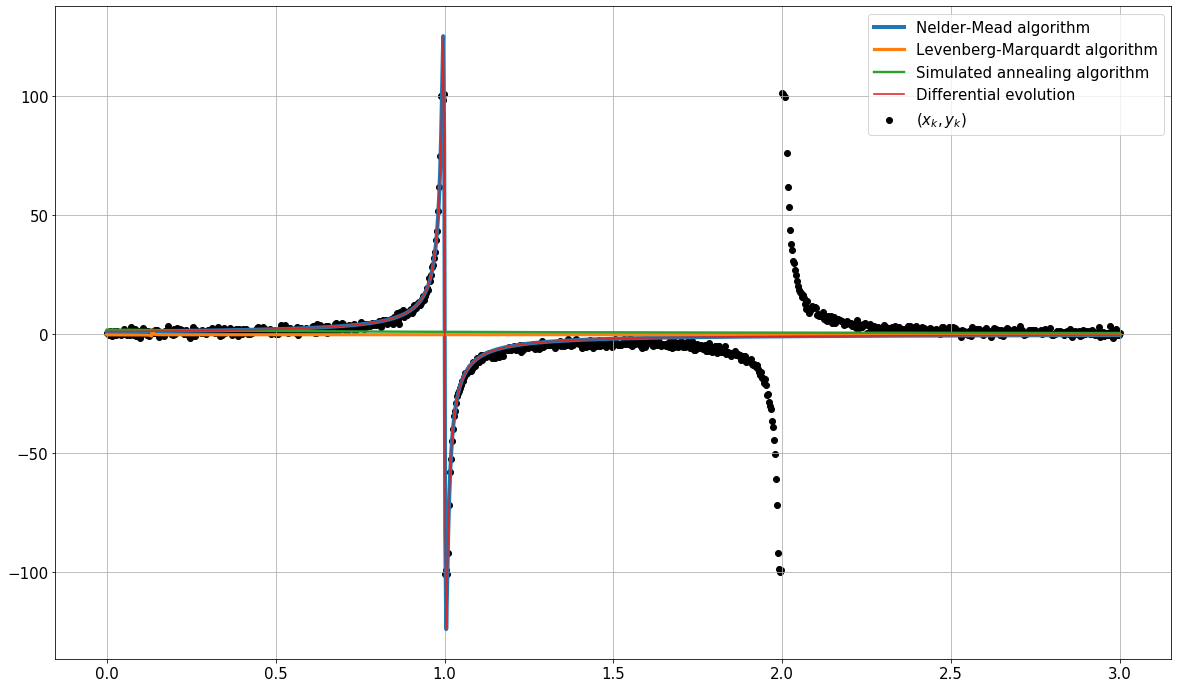

In [262]:
# Vizualization

fig, ax = plt.subplots(figsize = (20, 12))

plt.scatter(x_arr, y_arr, c = 'k', label = 'Data')

for i in range(len(df.columns)):
    plt.plot(x_arr, approx_func(x_arr, df[df.columns[i]][df.index[:-3]]), linewidth = (len(df.columns) - i + 1) * 0.8)

plt.legend(list(df.columns)[:] + ['$(x_k, y_k)$'])
plt.grid()

#fig.savefig('first_res.png')

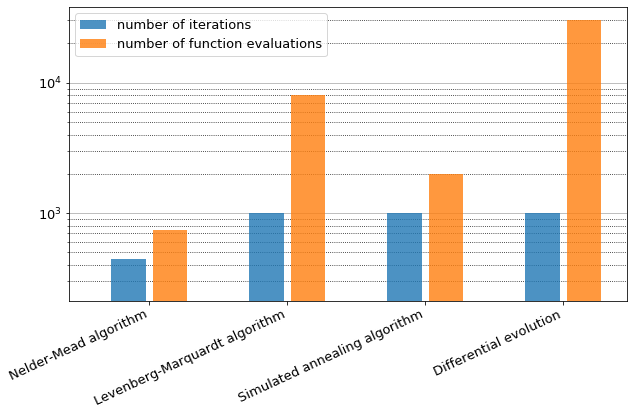

In [273]:
# Vizualization -numbers of iterations and iterations comparisson

mpl.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(figsize = (10, 6))

ax = plt.axes()
ax.yaxis.grid(True, zorder = 2)

algos_names = list(df.columns)
xs = range(len(algos_names))


plt.yscale('log')

plt.bar([x - 0.15  for x in xs], [df[key]['number of iterations'] for key in algos_names],\
        width = 0.25, alpha = 0.8, label = 'number of iterations', zorder = 2)

plt.bar([x + 0.15 for x in xs], [df[key]['number of function evaluations'] for key in algos_names],\
        width = 0.25, alpha = 0.8, label = 'number of function evaluations', zorder = 2)

plt.bar([0], [300], alpha = 0)

plt.xticks([i for i in xs], algos_names)
plt.legend(loc = 'best')

plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')

fig.autofmt_xdate(rotation = 25)
#fig.savefig('bars.png')

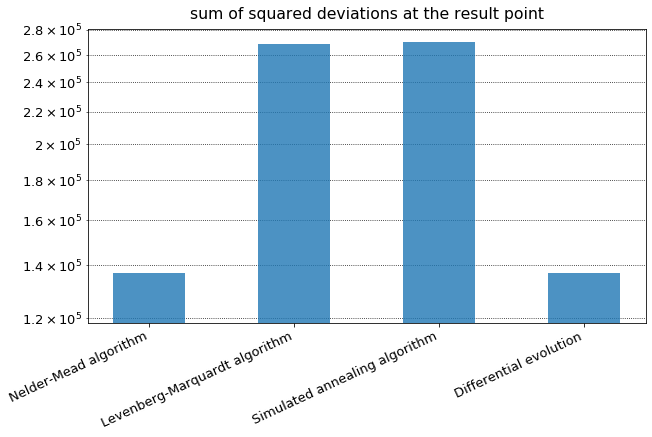

In [277]:
# Vizualization - comparison of the result

mpl.rcParams.update({'font.size': 13})
fig = plt.figure(figsize = (10, 6))

ax = plt.axes()
ax.yaxis.grid(True, zorder = 2)
plt.title('sum of squared deviations at the result point', pad = 10)

algos_names = df.columns
xs = range(len(algos_names))

plt.yscale('log')
plt.bar([x  for x in xs], [df[key]['sum of squared deviations'] for key in algos_names], \
        width = 0.5, alpha = 0.8, label = 'sum of squared deviations', zorder = 2)

plt.xticks([i for i in xs], algos_names)
#plt.legend(loc = 'best')

ax.grid(which='minor', 
        color = 'k', 
        linestyle = ':')

fig.autofmt_xdate(rotation = 25)
#fig.savefig('bars_1.png')

-------------------------------------------------------------------------------------------------------------------------------

### 4.2 Choose at least 15 cities in the world having land transport connections between them. Calculate the distance matrix for them and then apply the Simulated Annealing method to solve the corresponding Travelling Salesman Problem. 

### Visualize the results at the first and the last iteration. If necessary, use the city dataset from https://people.sc.fsu.edu/~jburkardt/datasets/cities/cities.html

In [159]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
global dist_arr


# Reading the distance matrix from that link

dist_file = open('15dist.txt', 'r')
dist_arr = [[] for i in range(15)]
j = 0

for line in dist_file:
    
    str_num = ''

    for i in range(len(line)):
        
        if line[i] != ' ':
            str_num += line[i]
        elif str_num != '':
            dist_arr[j].append(int(str_num))
            str_num = ''
    
    j += 1
    
dist_file.close()
dist_arr = np.array(dist_arr)
dist_arr

array([[ 0, 29, 82, 46, 68, 52, 72, 42, 51, 55, 29, 74, 23, 72, 46],
       [29,  0, 55, 46, 42, 43, 43, 23, 23, 31, 41, 51, 11, 52, 21],
       [82, 55,  0, 68, 46, 55, 23, 43, 41, 29, 79, 21, 64, 31, 51],
       [46, 46, 68,  0, 82, 15, 72, 31, 62, 42, 21, 51, 51, 43, 64],
       [68, 42, 46, 82,  0, 74, 23, 52, 21, 46, 82, 58, 46, 65, 23],
       [52, 43, 55, 15, 74,  0, 61, 23, 55, 31, 33, 37, 51, 29, 59],
       [72, 43, 23, 72, 23, 61,  0, 42, 23, 31, 77, 37, 51, 46, 33],
       [42, 23, 43, 31, 52, 23, 42,  0, 33, 15, 37, 33, 33, 31, 37],
       [51, 23, 41, 62, 21, 55, 23, 33,  0, 29, 62, 46, 29, 51, 11],
       [55, 31, 29, 42, 46, 31, 31, 15, 29,  0, 51, 21, 41, 23, 37],
       [29, 41, 79, 21, 82, 33, 77, 37, 62, 51,  0, 65, 42, 59, 61],
       [74, 51, 21, 51, 58, 37, 37, 33, 46, 21, 65,  0, 61, 11, 55],
       [23, 11, 64, 51, 46, 51, 51, 33, 29, 41, 42, 61,  0, 62, 23],
       [72, 52, 31, 43, 65, 29, 46, 31, 51, 23, 59, 11, 62,  0, 59],
       [46, 21, 51, 64, 23, 59, 33

In [168]:
# Working part

def distance_func(path):
    
    ans = 0
    len_p = len(path)
    for i in range(len_p - 1):
        ans += dist_arr[path[i]][path[(i + 1) % len_p]]
        
    return ans


def dist_neighbour(path):
    
    ans = path[:]
    num_1, num_2 = random.sample([i for i in range(1, len(path) - 1)], 2)[:]
    ans[num_1], ans[num_2] = ans[num_2], ans[num_1]
    
    return ans


def simulated_annealing(initial_approx = [i % 15 for i in range(16)], gamma = 1e-3):
    
    """ temperature will decrease by the law temp_i+1 = temp_i - gamma,
    where gamma is a number close to the value 0 (i.e. = 0.001)"""
    
    func_eval_num, iter_num = 0, 0
    temp_i, counter = 1, 0
    
    first_iter_res = {'sequence of cities' : initial_approx, 'total path length' : distance_func(initial_approx)}
    
    args_prev = np.array(initial_approx)
    func_prev = distance_func(args_prev)
            
    args_i = dist_neighbour(args_prev)
    func_i = distance_func(args_i)
        
    if func_i <= func_prev:
        args_curr = args_i
    else:
        p = np.exp((func_prev - func_i) / temp_i)
        args_curr = random.choices([args_i, args_prev], weights = [p, 1 - p])[0]
        counter += (args_curr == args_i).mean()

    temp_i -= gamma
    func_eval_num += 2
    iter_num += 1
    
    while (temp_i > 0) :
        
        args_prev = args_curr
        func_prev = distance_func(args_prev)
        
        args_i = dist_neighbour(args_prev)
        func_i = distance_func(args_i)
        
        if func_i <= func_prev:
            args_curr = args_i
        else:
            p = np.exp((func_prev - func_i) / temp_i)
            args_curr = random.choices([args_i, args_prev], weights = [p, 1 - p])[0]
            counter += (args_curr == args_i)[0]
            
        temp_i -= gamma
        func_eval_num += 2
        iter_num += 1
        
    print(" number of iterations: ", iter_num, "\n number of random assignments: ", counter)
    
    last_iter_res = {'sequence of cities' : args_curr, 'total path length' : distance_func(args_curr)}
    
    return {'first iteration' : first_iter_res, 'last iteration' : last_iter_res}


df = pd.DataFrame(simulated_annealing()).T
df

 number of iterations:  1000 
 number of random assignments:  481


,sequence of cities,total path length
first iteration,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",817
last iteration,"[0, 10, 5, 1, 11, 2, 6, 8, 9, 7, 3, 13, 4, 12,...",521


In [169]:
# In this case, the solution found is not the best

best_path = [1, 13, 2, 15, 9, 5, 7, 3, 12, 14, 10, 8, 6, 4, 11, 1]

for i in range(len(best_path)):
    best_path[i] -= 1

new_row = pd.Series(data = {'sequence of cities' : best_path, 'total path length': distance_func(best_path)}, \
                    name = 'best case')
df = df.append(new_row, ignore_index = False)
df

,sequence of cities,total path length
first iteration,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",817
last iteration,"[0, 10, 5, 1, 11, 2, 6, 8, 9, 7, 3, 13, 4, 12,...",521
best case,"[0, 12, 1, 14, 8, 4, 6, 2, 11, 13, 9, 7, 5, 3,...",291


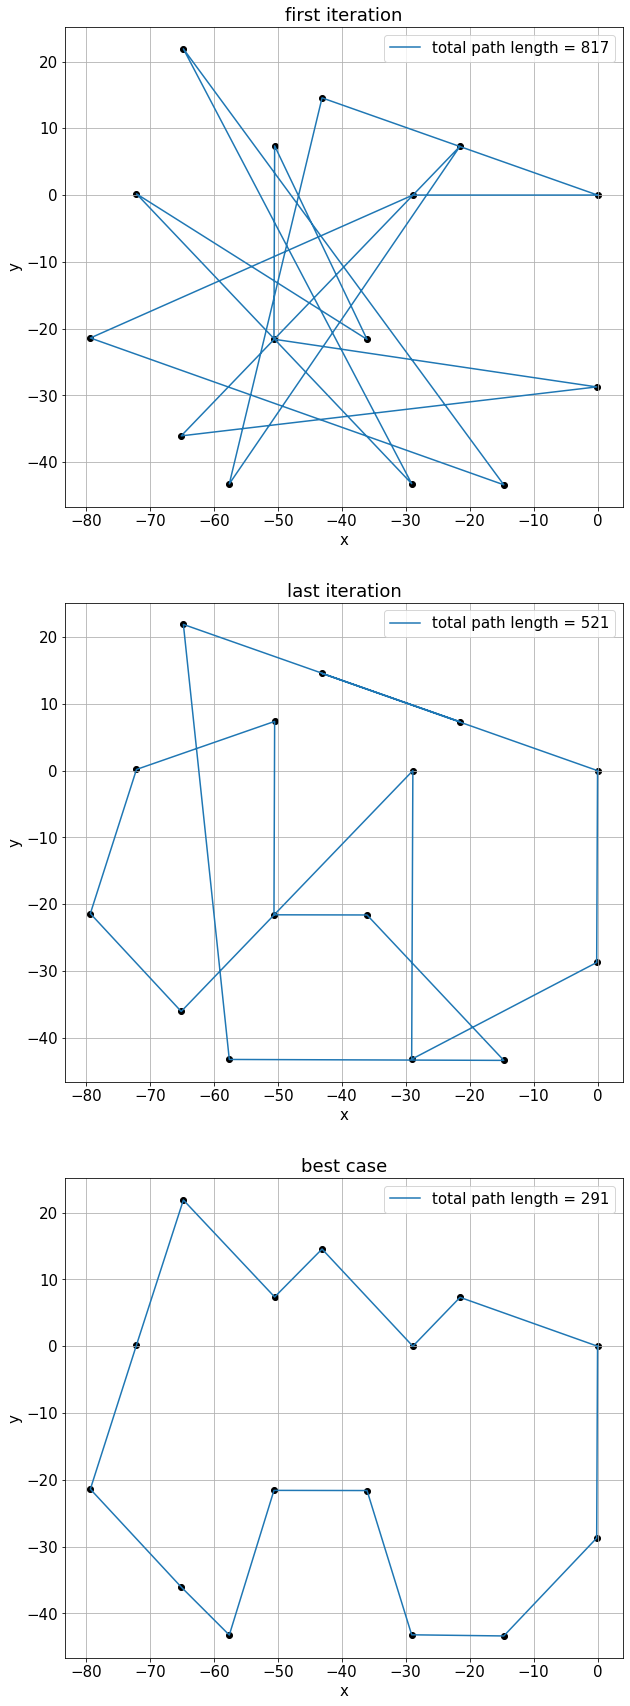

In [171]:
# Vizualization:

coord_file = open('15coord.txt', 'r')
coord_arr = [[] for i in range(15)]
j = 0

for line in coord_file:
    
    str_num = ''

    for i in range(len(line)):
        
        if line[i] != ' ':
            str_num += line[i]
        elif str_num != '':
            coord_arr[j].append(float(str_num))
            str_num = ''
    
    j += 1
    
coord_file.close()
coord_arr = np.array(coord_arr)

x_arr = [coord_arr[i][0] for i in range(len(coord_arr))]
y_arr = [coord_arr[i][1] for i in range(len(coord_arr))]

fig, ax = plt.subplots(figsize = (10, 30))

for i in range(3):
    
    plt.subplot(3, 1, i + 1)
    plt.title(df.index[i])
    
    plt.scatter(x_arr, y_arr, c = 'k')
    plt.plot([x_arr[i] for i in df[df.columns[0]][df.index[i]]], [y_arr[i] for i in df[df.columns[0]][df.index[i]]])
    
    plt.legend(['total path length = {}'.format(df[df.columns[1]][df.index[i]])])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    
#fig.savefig('salesman_problem_2.png')